In [151]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as spicystats
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from pandas.plotting import scatter_matrix
import statsmodels.api as sm

import sys
sys.path.insert(0, 'src')
from sklearn.preprocessing import StandardScaler

In [183]:
# load and clean dataset, train-test split

loan_data = pd.read_csv('data/loan_data.csv')
loan_data['amount_funded_by_investors'].replace(-0.01, 0.00, inplace=True)
X = loan_data.drop('interest_rate', axis=1)
y = loan_data['interest_rate']

# np.sort(X.fico_range.unique())
fico_dict = {idx+1:val for idx, val in enumerate(np.sort(X.fico_range.unique()))}
fico_df = pd.DataFrame([fico_dict]).T.rename(columns={0: 'fico_range'})
fico_df['fico_cat'] = fico_df.index
fico_df
X = X.merge(fico_df, 'left', on='fico_range').drop('fico_range', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_test.sort_index().head(10)

In [ ]:
y_test.sort_index().head(10)

In [ ]:
sns.pairplot(X_train)

In [194]:
model = LinearRegression()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

model_info = sm.OLS(y_train, X_train)
model_info.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          interest_rate   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              8195.
Date:                Tue, 24 Jan 2023   Prob (F-statistic):                        0.00
Time:                        10:17:48   Log-Likelihood:                         -5204.3
No. Observations:                1998   AIC:                                  1.042e+04
Df Residuals:                    1994   BIC:                                  1.044e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
amount_requested            5.769e-05   3.88e-05      1.487      0.137   -1.84e-05       0.000
amount_funded_by_investors   6.71e-05    3.9e-05      1.721      0.085   -9.38e-06       0.000
loan_length                    0.3659      0.005     78.358      0.000       0.357       0.375
fico_cat                      -0.2862      0.010    -29.608      0.000      -0.305      -0.267
==============================================================================
Omnibus:                       50.967   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.223
Skew:                          -0.374   Prob(JB):                     1.02e-12
Kurtosis:                       3.322   Cond. No.                     2.83e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [188]:
def rmse(true, predicted):
    mse = mean_squared_error(true, predicted)
    return np.sqrt(mse)


def cross_val(X_train, y_train, k):    
    kf = KFold(k)
    kf.get_n_splits(X_train)

    # print(kf.split(X_train))

    train_dict = {}
    test_dict = {}

    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        # print(f'Fold {i}:')
        # print(f"Train: index={train_index}")
        # print(f"Test: index={test_index}")
        
        X_train_kfold = X_train.iloc[train_index]
        y_train_kfold = y_train.iloc[train_index]
        X_test_kfold = X_train.iloc[test_index]
        y_test_kfold = y_train.iloc[test_index]

        reg = LinearRegression()
        reg.fit(X_train_kfold, y_train_kfold)

        # Call predict to get the predicted values for training and test set
        train_predicted = reg.predict(X_train_kfold)
        test_predicted = reg.predict(X_test_kfold)

        # Calculate RMSE for training and test set
        train_dict[i] = rmse(y_train_kfold, train_predicted)
        test_dict[i] = rmse(y_test_kfold, test_predicted)

    return np.mean(list(train_dict.values())), np.mean(list(test_dict.values()))

In [202]:
# RMSE for model 1

rmse(y_test, y_hat)

2.1328790231013133

In [193]:
# RMSE of training and test set with K-folds for model 1

cross_val(X_train, y_train, 5)

(2.0955569312561764, 2.1016394881660525)

In [ ]:
# Residual plot for each individual feature

fig, ax = plt.subplots(4,1)

def residual_plot(ax, x, y, y_hat, n_bins=100):
    residuals = y - y_hat
    ax.axhline(0, color="black", linestyle="--")
    ax.scatter(x, residuals, color="grey", alpha=0.5)
    ax.set_ylabel("Residuals ($y - \hat y$)")

for idx, val in enumerate(X_test.columns):
    residual_plot(ax[idx], X_test[val], y_test, y_hat)

In [ ]:
# Residual plot for entire model

fig, ax = plt.subplots()
residual_plot(ax, X_test.index, y_test, y_hat)

In [200]:
# Model 2

X2 = X[['loan_length', 'fico_cat']]
y2 = y
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)
model2 = LinearRegression()
model2.fit(X2_train, y2_train)
y2_hat = model2.predict(X2_test)

In [201]:
rmse(y2_test, y2_hat)

2.292172767890173

In [203]:
cross_val(X2_train, y2_train, 5)

(2.332798860935848, 2.3344100126563836)

In [ ]:
model2_info = sm.OLS(y2_train, X2_train)
model2_info.fit().summary()

ValueError: x and y must be the same size

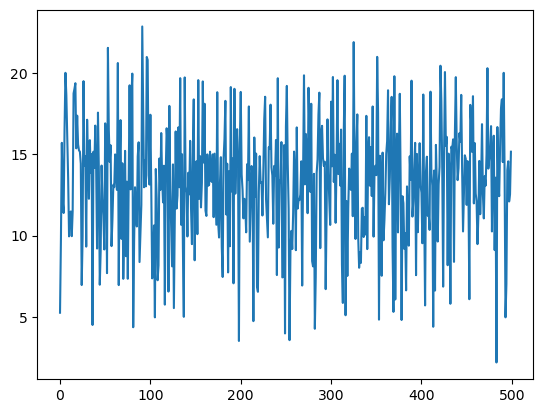